# Annotator Competence Analysis

This notebook analyzes how annotator competences evolved over time, examining:
- Distribution of changes in annotations
- Differences between annotator groups
- Correlations between certainty and quality metrics

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load data
data_path = Path("annotated_results_full.csv")
df = pd.read_csv(data_path)

# Convert certainty text values to numeric scale
certainty_mapping = {
    'Niska pewność': 1,
    'Umiarkowana pewność': 2,
    'Wysoka pewność': 3,
    'Całkowita pewność': 4
}

df['first_question_10_certainty'] = df['first_question_10_certainty'].map(certainty_mapping)
df['repeated_question_10_certainty'] = df['repeated_question_10_certainty'].map(certainty_mapping)

# Define numeric columns that should be float
numeric_cols = [
    'first_question_3_intention_clarity',
    'repeated_question_3_intention_clarity',
    'reaction_semantic_similarity',
    'intention_semantic_similarity',
    'reaction_evolution_assessment_quality_change',
    'intention_evolution_assessment_quality_change',
    'reaction_types_analysis_before_types_emocjonalne',
    'reaction_types_analysis_before_types_kognitywne',
    'reaction_types_analysis_before_types_behawioralne_manifestacje',
    'reaction_types_analysis_before_types_zewnętrzne_wyniki',
    'reaction_types_analysis_after_types_emocjonalne',
    'reaction_types_analysis_after_types_kognitywne',
    'reaction_types_analysis_after_types_behawioralne_manifestacje',
    'reaction_types_analysis_after_types_zewnętrzne_wyniki'
]

# Convert numeric columns to proper types
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate certainty change immediately after loading
df['certainty_change'] = df['repeated_question_10_certainty'] - df['first_question_10_certainty']

print(f"Loaded {len(df)} rows with {len(df.columns)} columns")
print(f"\nCertainty mapping applied:")
print(f"  Niska pewność → 1")
print(f"  Umiarkowana pewność → 2")
print(f"  Wysoka pewność → 3")
print(f"  Całkowita pewność → 4")
print(f"\nCertainty value distribution:")
print(f"  First question: {df['first_question_10_certainty'].value_counts().sort_index().to_dict()}")
print(f"  Repeated question: {df['repeated_question_10_certainty'].value_counts().sort_index().to_dict()}")
print(f"\nColumns: {list(df.columns[:10])}...")  # Show first 10 columns

Loaded 750 rows with 54 columns

Certainty mapping applied:
  Niska pewność → 1
  Umiarkowana pewność → 2
  Wysoka pewność → 3
  Całkowita pewność → 4

Certainty value distribution:
  First question: {1.0: 39, 2.0: 215, 3.0: 397, 4.0: 63}
  Repeated question: {1.0: 15, 2.0: 147, 3.0: 445, 4.0: 129}

Columns: ['first_question_4_intention', 'repeated_question_4_intention', 'first_question_9_reaction', 'repeated_question_9_reaction', 'id', 'example', 'annotator', 'first_question_10_certainty', 'repeated_question_10_certainty', 'annotator_group']...


## 1. Data Overview

In [18]:
# Basic statistics
print("Dataset shape:", df.shape)
print("\nAnnotator groups:")
print(df['annotator_group'].value_counts())
print("\nNumber of unique annotators:", df['annotator'].nunique())
print("\nMissing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset shape: (750, 53)

Annotator groups:
annotator_group
komunikacja    150
rodzic         150
psycholog      150
nauczyciel     150
nastolatek     150
Name: count, dtype: int64

Number of unique annotators: 25

Missing values:
first_question_4_intention                73
repeated_question_4_intention             60
first_question_9_reaction                204
repeated_question_9_reaction             198
first_question_10_certainty               33
repeated_question_10_certainty            11
first_question_3_intention_clarity        59
repeated_question_3_intention_clarity     69
dtype: int64


## 2. Reaction analysis - quality change distribution

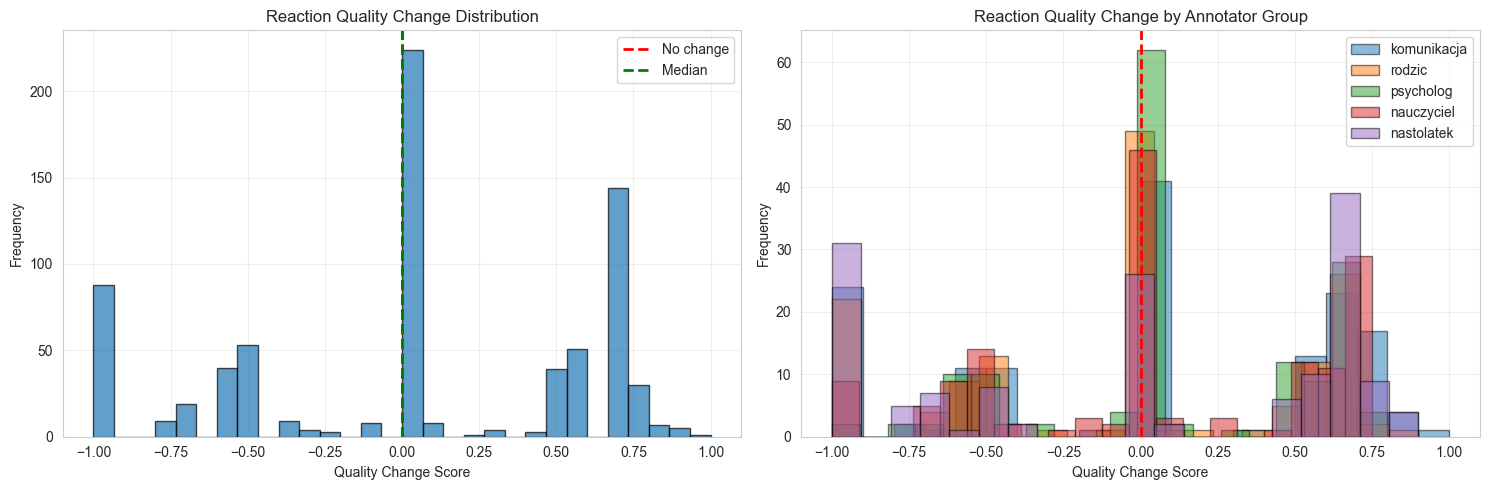

Reaction Quality Change Statistics:
count    750.000000
mean       0.030333
std        0.587074
min       -1.000000
25%       -0.500000
50%        0.000000
75%        0.600000
max        1.000000
Name: reaction_evolution_assessment_quality_change, dtype: float64

Improvement rate: 39.1%
Decline rate: 31.1%
No change rate: 29.9%


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(df['reaction_evolution_assessment_quality_change'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
axes[0].axvline(df['reaction_evolution_assessment_quality_change'].median(), 
                color='green', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Quality Change Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Reaction Quality Change Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# By annotator group (overlaid)
for group in df['annotator_group'].unique():
    group_data = df[df['annotator_group'] == group]['reaction_evolution_assessment_quality_change']
    axes[1].hist(group_data, bins=20, alpha=0.5, label=f'{group}', edgecolor='black')

axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Quality Change Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reaction Quality Change by Annotator Group')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("Reaction Quality Change Statistics:")
print(df['reaction_evolution_assessment_quality_change'].describe())
print(f"\nImprovement rate: {(df['reaction_evolution_assessment_quality_change'] > 0).mean():.1%}")
print(f"Decline rate: {(df['reaction_evolution_assessment_quality_change'] < 0).mean():.1%}")
print(f"No change rate: {(df['reaction_evolution_assessment_quality_change'] == 0).mean():.1%}")

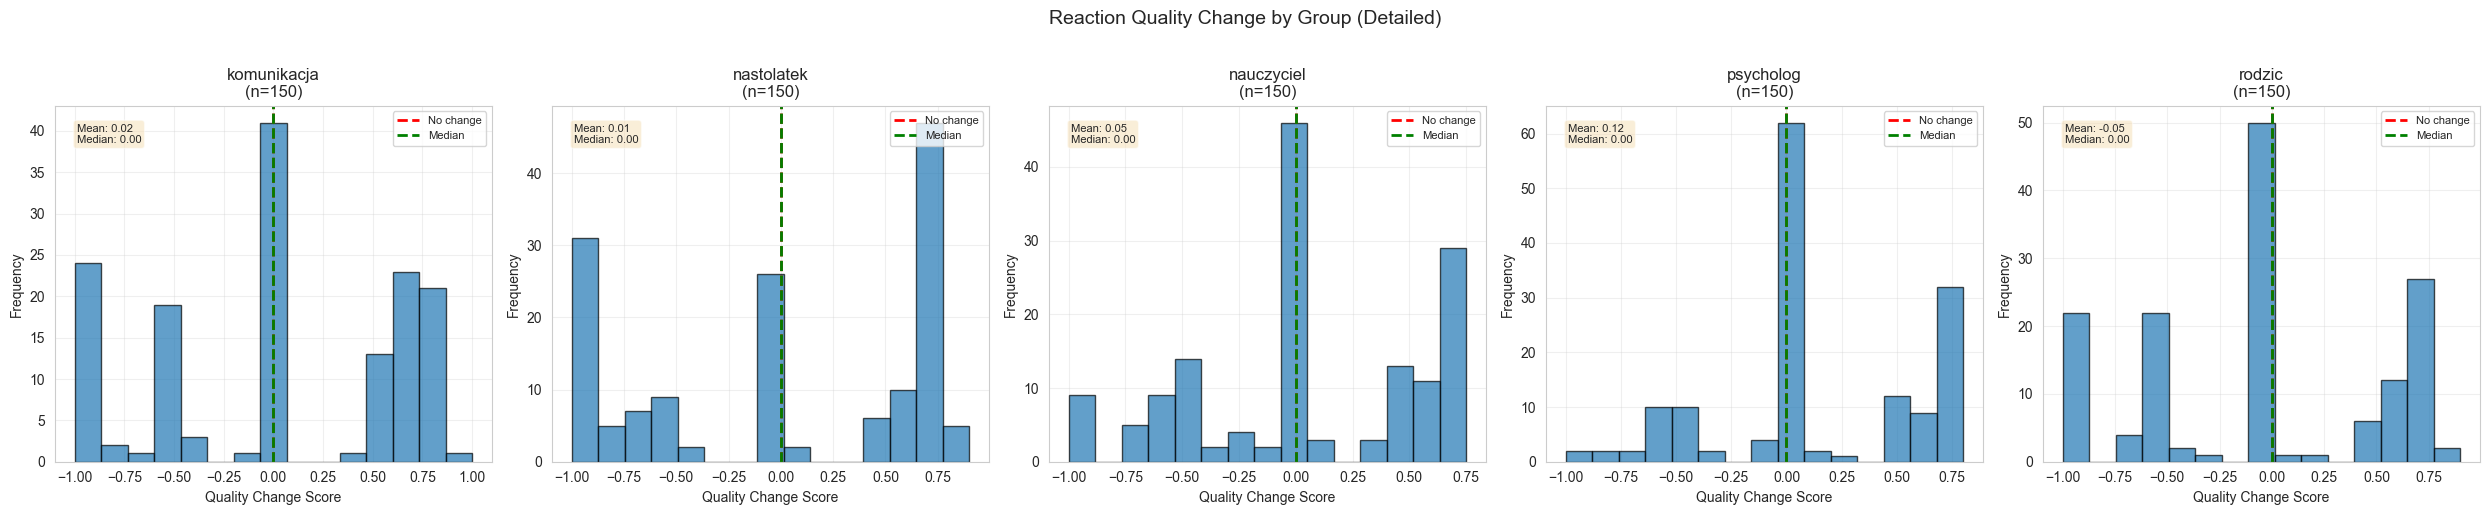

In [20]:
# Detailed per-group analysis for Reaction Quality Change
groups = sorted(df['annotator_group'].unique())
n_groups = len(groups)
fig, axes = plt.subplots(1, n_groups, figsize=(5*n_groups, 5))

if n_groups == 1:
    axes = [axes]

for idx, group in enumerate(groups):
    group_data = df[df['annotator_group'] == group]['reaction_evolution_assessment_quality_change']
    
    axes[idx].hist(group_data, bins=15, edgecolor='black', alpha=0.7)
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
    axes[idx].axvline(group_data.median(), color='green', linestyle='--', linewidth=2, label='Median')
    axes[idx].set_xlabel('Quality Change Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{group}\n(n={len(group_data)})')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)
    
    # Add stats text
    stats_text = f'Mean: {group_data.mean():.2f}\nMedian: {group_data.median():.2f}'
    axes[idx].text(0.05, 0.95, stats_text, transform=axes[idx].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=8)

plt.suptitle('Reaction Quality Change by Group (Detailed)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Intention analysis - quality change distribution

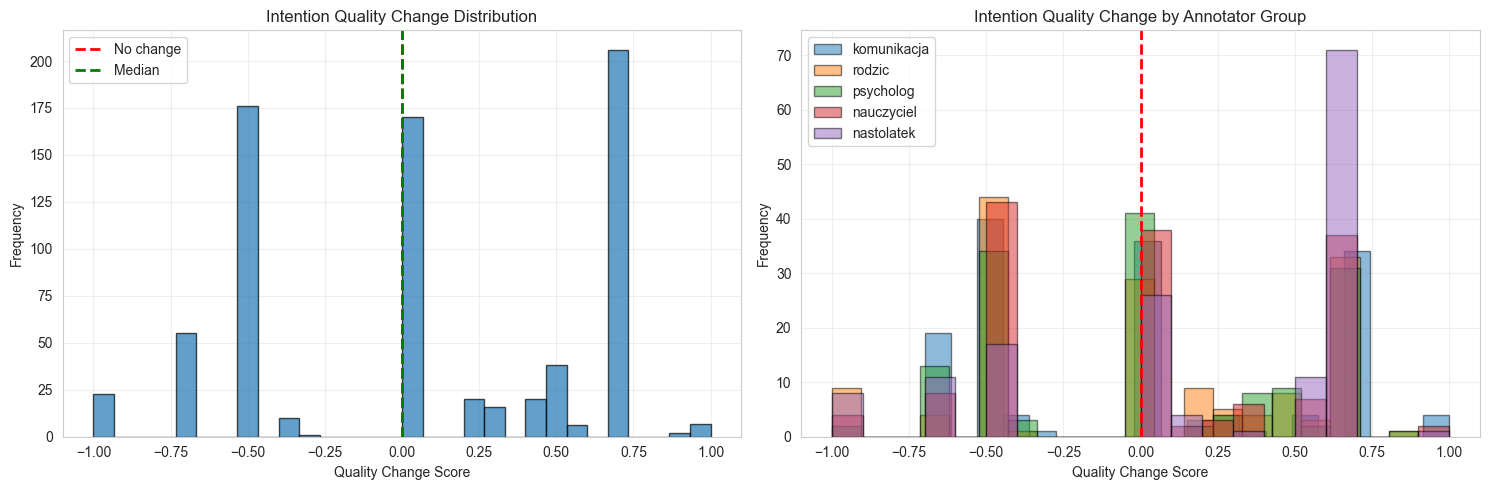

Intention Quality Change Statistics:
count    750.000000
mean       0.051467
std        0.542350
min       -1.000000
25%       -0.500000
50%        0.000000
75%        0.700000
max        1.000000
Name: intention_evolution_assessment_quality_change, dtype: float64

Improvement rate: 42.0%
Decline rate: 35.3%
No change rate: 22.7%


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(df['intention_evolution_assessment_quality_change'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
axes[0].axvline(df['intention_evolution_assessment_quality_change'].median(), 
                color='green', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Quality Change Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Intention Quality Change Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# By annotator group (overlaid)
for group in df['annotator_group'].unique():
    group_data = df[df['annotator_group'] == group]['intention_evolution_assessment_quality_change']
    axes[1].hist(group_data, bins=20, alpha=0.5, label=f'{group}', edgecolor='black')

axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Quality Change Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Intention Quality Change by Annotator Group')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("Intention Quality Change Statistics:")
print(df['intention_evolution_assessment_quality_change'].describe())
print(f"\nImprovement rate: {(df['intention_evolution_assessment_quality_change'] > 0).mean():.1%}")
print(f"Decline rate: {(df['intention_evolution_assessment_quality_change'] < 0).mean():.1%}")
print(f"No change rate: {(df['intention_evolution_assessment_quality_change'] == 0).mean():.1%}")

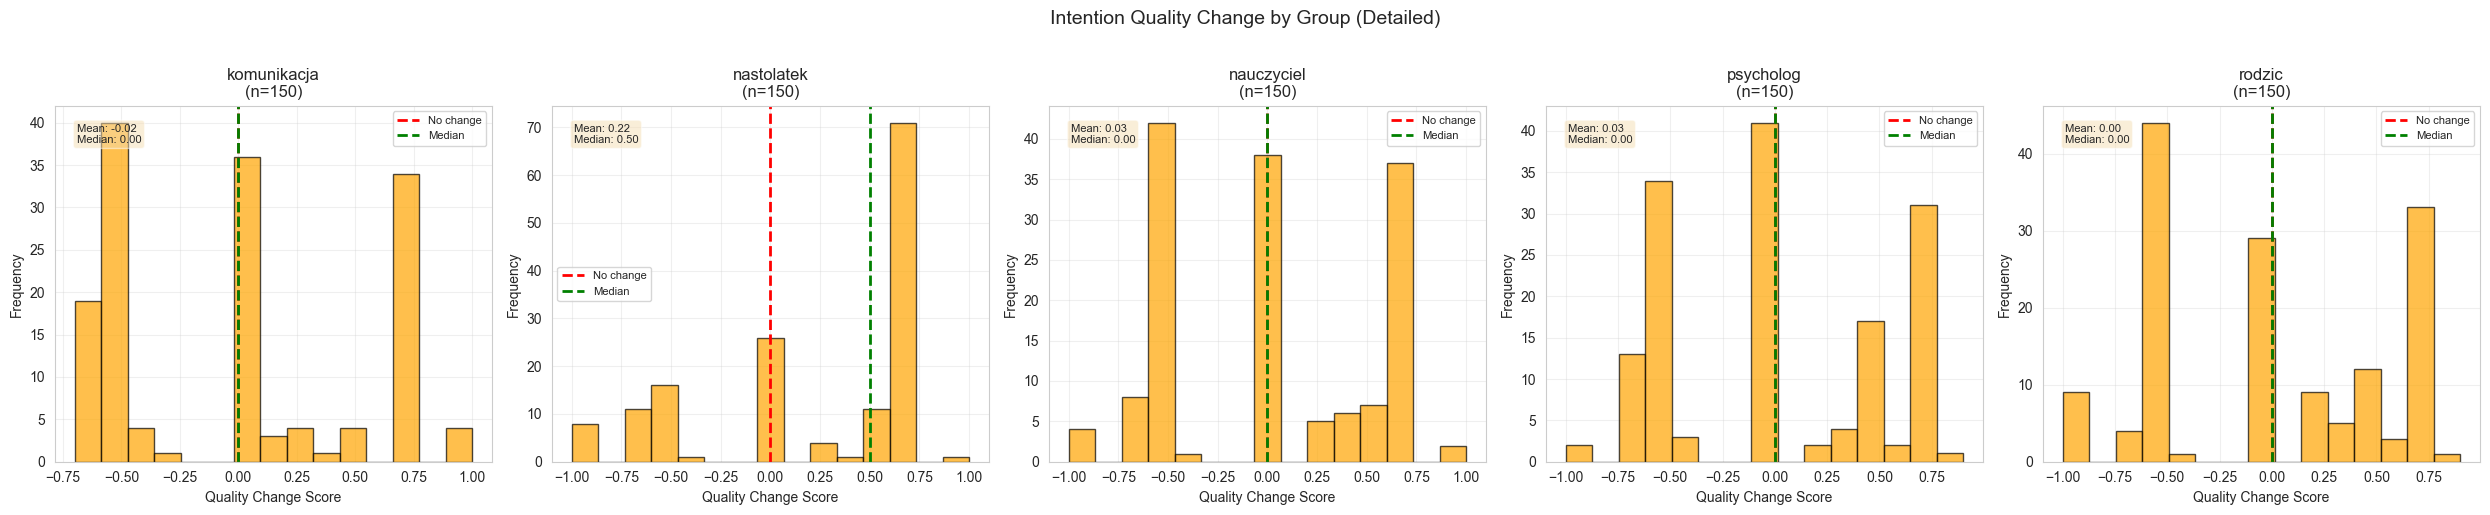

In [22]:
# Detailed per-group analysis for Intention Quality Change
groups = sorted(df['annotator_group'].unique())
n_groups = len(groups)
fig, axes = plt.subplots(1, n_groups, figsize=(5*n_groups, 5))

if n_groups == 1:
    axes = [axes]

for idx, group in enumerate(groups):
    group_data = df[df['annotator_group'] == group]['intention_evolution_assessment_quality_change']
    
    axes[idx].hist(group_data, bins=15, edgecolor='black', alpha=0.7, color='orange')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
    axes[idx].axvline(group_data.median(), color='green', linestyle='--', linewidth=2, label='Median')
    axes[idx].set_xlabel('Quality Change Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{group}\n(n={len(group_data)})')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)
    
    # Add stats text
    stats_text = f'Mean: {group_data.mean():.2f}\nMedian: {group_data.median():.2f}'
    axes[idx].text(0.05, 0.95, stats_text, transform=axes[idx].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=8)

plt.suptitle('Intention Quality Change by Group (Detailed)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Comparison: Reaction vs Intention Changes

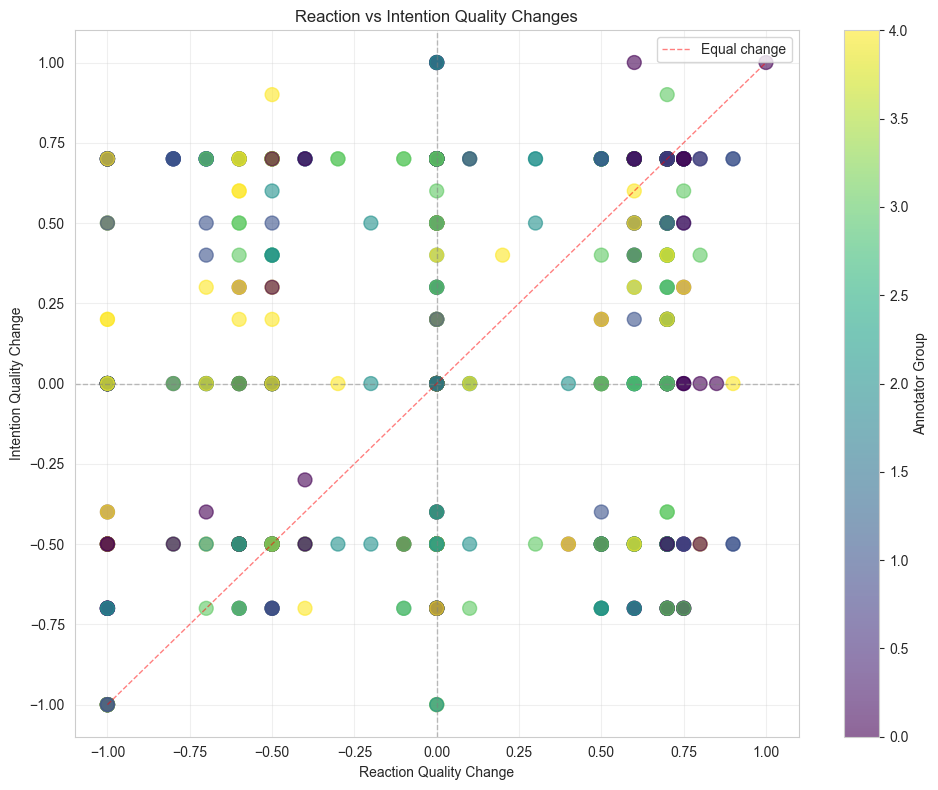

Correlation between Reaction and Intention quality changes: 0.204

Paired t-test: t=-0.811, p=0.4174
Mean difference: -0.021


In [23]:
# Scatter plot: Reaction vs Intention quality changes
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(
    df['reaction_evolution_assessment_quality_change'],
    df['intention_evolution_assessment_quality_change'],
    c=df['annotator_group'].astype('category').cat.codes,
    cmap='viridis',
    alpha=0.6,
    s=100
)

# Add reference lines
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.plot([-1, 1], [-1, 1], 'r--', linewidth=1, alpha=0.5, label='Equal change')

ax.set_xlabel('Reaction Quality Change')
ax.set_ylabel('Intention Quality Change')
ax.set_title('Reaction vs Intention Quality Changes')
ax.grid(alpha=0.3)
ax.legend()

# Add colorbar for groups
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Annotator Group')

plt.tight_layout()
plt.show()

# Correlation
correlation = df[['reaction_evolution_assessment_quality_change', 
                  'intention_evolution_assessment_quality_change']].corr().iloc[0, 1]
print(f"Correlation between Reaction and Intention quality changes: {correlation:.3f}")

# Test for significant difference
t_stat, p_value = stats.ttest_rel(
    df['reaction_evolution_assessment_quality_change'].dropna(),
    df['intention_evolution_assessment_quality_change'].dropna()
)
print(f"\nPaired t-test: t={t_stat:.3f}, p={p_value:.4f}")
print(f"Mean difference: {df['reaction_evolution_assessment_quality_change'].mean() - df['intention_evolution_assessment_quality_change'].mean():.3f}")

## 5. Depth Analysis - Before vs After

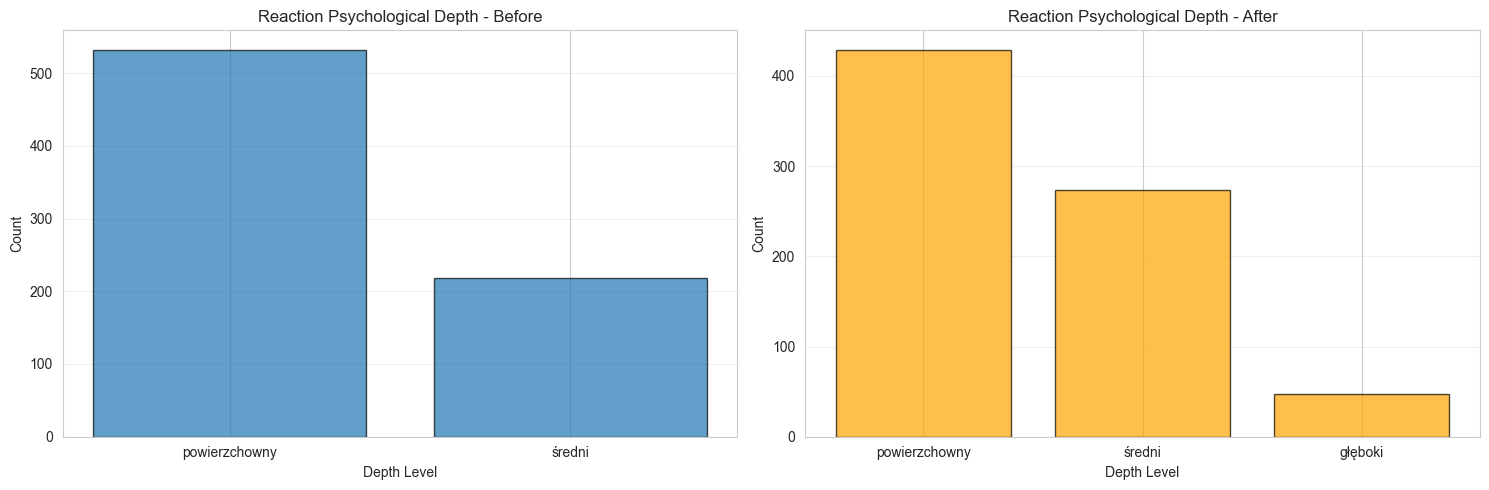

Reaction Depth Analysis:

Before:
reaction_psychological_depth_analysis_before_level
powierzchowny    0.709333
średni           0.290667
Name: proportion, dtype: float64

After:
reaction_psychological_depth_analysis_after_level
powierzchowny    0.572000
średni           0.365333
głęboki          0.062667
Name: proportion, dtype: float64


In [24]:
# Reaction depth changes - Overall
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before
before_counts = df['reaction_psychological_depth_analysis_before_level'].value_counts()
axes[0].bar(before_counts.index, before_counts.values, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Depth Level')
axes[0].set_ylabel('Count')
axes[0].set_title('Reaction Psychological Depth - Before')
axes[0].grid(alpha=0.3, axis='y')

# After
after_counts = df['reaction_psychological_depth_analysis_after_level'].value_counts()
axes[1].bar(after_counts.index, after_counts.values, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Depth Level')
axes[1].set_ylabel('Count')
axes[1].set_title('Reaction Psychological Depth - After')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Reaction Depth Analysis:")
print("\nBefore:")
print(df['reaction_psychological_depth_analysis_before_level'].value_counts(normalize=True))
print("\nAfter:")
print(df['reaction_psychological_depth_analysis_after_level'].value_counts(normalize=True))

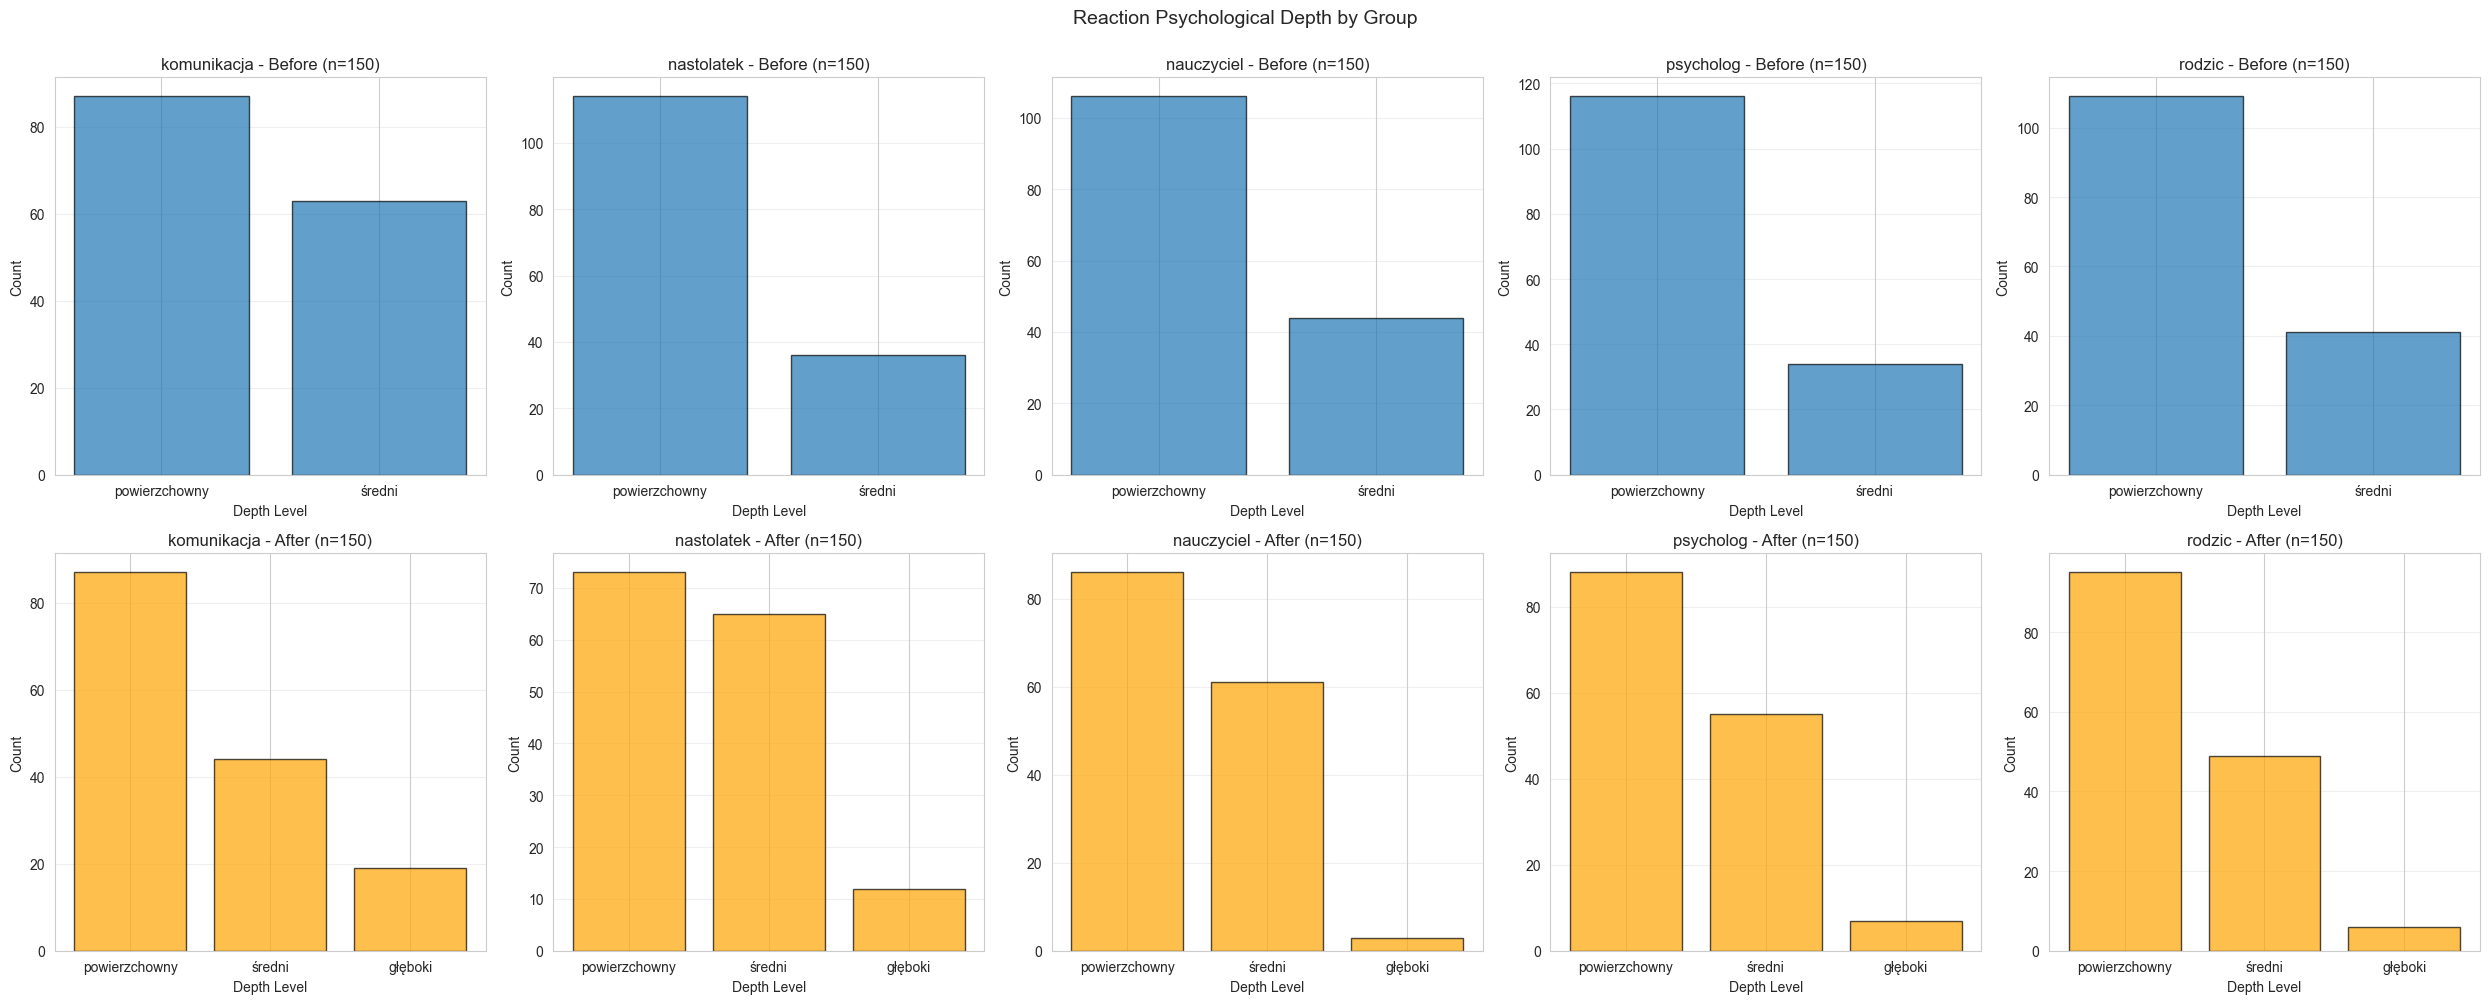

In [25]:
# Reaction depth changes - By Group (Detailed)
groups = sorted(df['annotator_group'].unique())
n_groups = len(groups)
fig, axes = plt.subplots(2, n_groups, figsize=(5*n_groups, 10))

if n_groups == 1:
    axes = axes.reshape(2, 1)

for idx, group in enumerate(groups):
    group_data = df[df['annotator_group'] == group]
    
    # Before
    before_counts = group_data['reaction_psychological_depth_analysis_before_level'].value_counts()
    axes[0, idx].bar(before_counts.index, before_counts.values, edgecolor='black', alpha=0.7)
    axes[0, idx].set_xlabel('Depth Level')
    axes[0, idx].set_ylabel('Count')
    axes[0, idx].set_title(f'{group} - Before (n={len(group_data)})')
    axes[0, idx].grid(alpha=0.3, axis='y')
    
    # After
    after_counts = group_data['reaction_psychological_depth_analysis_after_level'].value_counts()
    axes[1, idx].bar(after_counts.index, after_counts.values, edgecolor='black', alpha=0.7, color='orange')
    axes[1, idx].set_xlabel('Depth Level')
    axes[1, idx].set_ylabel('Count')
    axes[1, idx].set_title(f'{group} - After (n={len(group_data)})')
    axes[1, idx].grid(alpha=0.3, axis='y')

plt.suptitle('Reaction Psychological Depth by Group', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

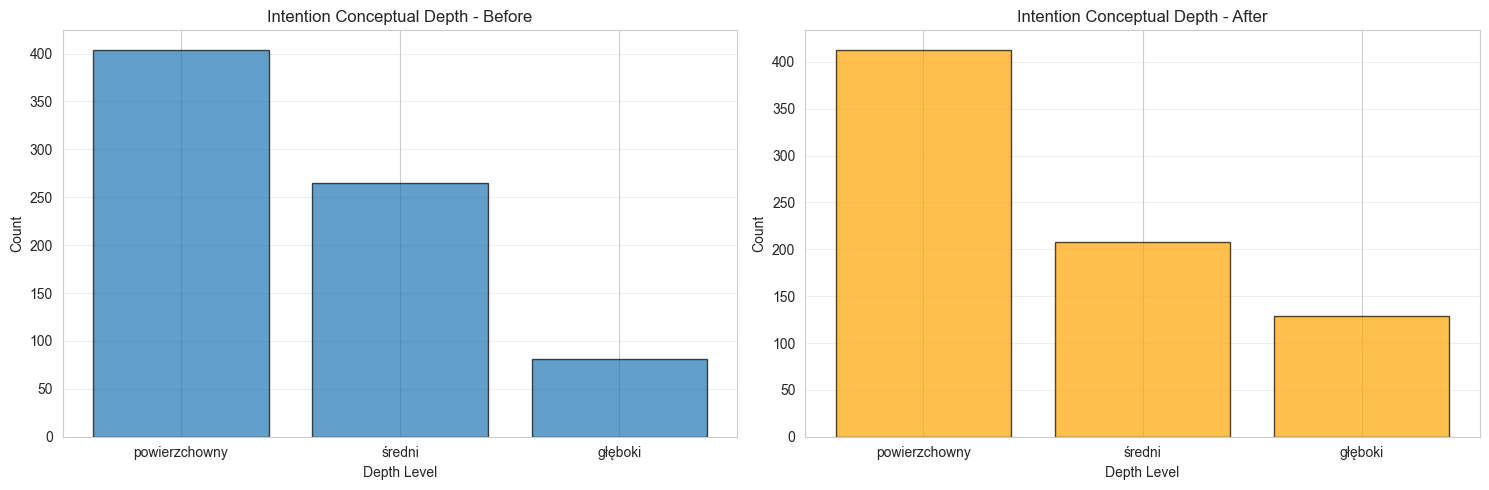

Intention Depth Analysis:

Before:
intention_conceptual_depth_analysis_before_level
powierzchowny    0.538667
średni           0.353333
głęboki          0.108000
Name: proportion, dtype: float64

After:
intention_conceptual_depth_analysis_after_level
powierzchowny    0.550667
średni           0.277333
głęboki          0.172000
Name: proportion, dtype: float64


In [26]:
# Intention depth changes - Overall
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before
before_counts = df['intention_conceptual_depth_analysis_before_level'].value_counts()
axes[0].bar(before_counts.index, before_counts.values, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Depth Level')
axes[0].set_ylabel('Count')
axes[0].set_title('Intention Conceptual Depth - Before')
axes[0].grid(alpha=0.3, axis='y')

# After
after_counts = df['intention_conceptual_depth_analysis_after_level'].value_counts()
axes[1].bar(after_counts.index, after_counts.values, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Depth Level')
axes[1].set_ylabel('Count')
axes[1].set_title('Intention Conceptual Depth - After')
axes[1].grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Intention Depth Analysis:")
print("\nBefore:")
print(df['intention_conceptual_depth_analysis_before_level'].value_counts(normalize=True))
print("\nAfter:")
print(df['intention_conceptual_depth_analysis_after_level'].value_counts(normalize=True))

## 6. Evolution Assessment Types Analysis

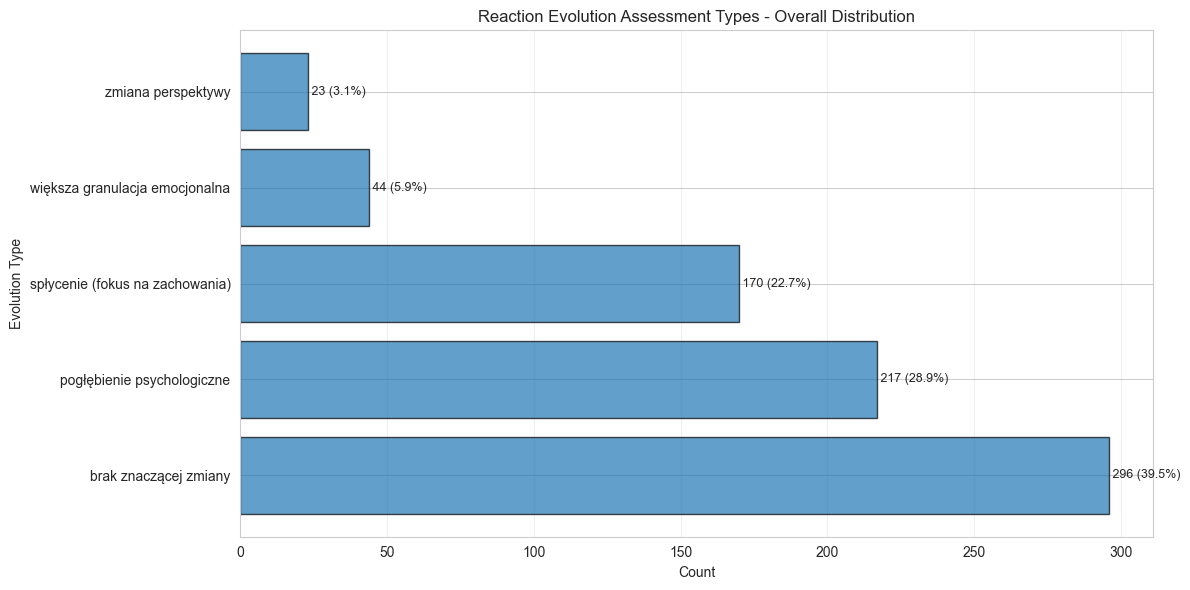

Reaction Evolution Assessment Types:
reaction_evolution_assessment_type
brak znaczącej zmiany              296
pogłębienie psychologiczne         217
spłycenie (fokus na zachowania)    170
większa granulacja emocjonalna      44
zmiana perspektywy                  23
Name: count, dtype: int64

Proportions:
reaction_evolution_assessment_type
brak znaczącej zmiany              39.5%
pogłębienie psychologiczne         28.9%
spłycenie (fokus na zachowania)    22.7%
większa granulacja emocjonalna      5.9%
zmiana perspektywy                  3.1%
Name: proportion, dtype: object


In [47]:
# Reaction evolution assessment types - Overall
reaction_type_counts = df['reaction_evolution_assessment_type'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(reaction_type_counts.index, reaction_type_counts.values, edgecolor='black', alpha=0.7)
ax.set_xlabel('Count')
ax.set_ylabel('Evolution Type')
ax.set_title('Reaction Evolution Assessment Types - Overall Distribution')
ax.grid(alpha=0.3, axis='x')

# Add value labels
for i, (idx, val) in enumerate(reaction_type_counts.items()):
    ax.text(val, i, f' {val} ({val/len(df)*100:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Reaction Evolution Assessment Types:")
print(df['reaction_evolution_assessment_type'].value_counts())
print("\nProportions:")
print(df['reaction_evolution_assessment_type'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

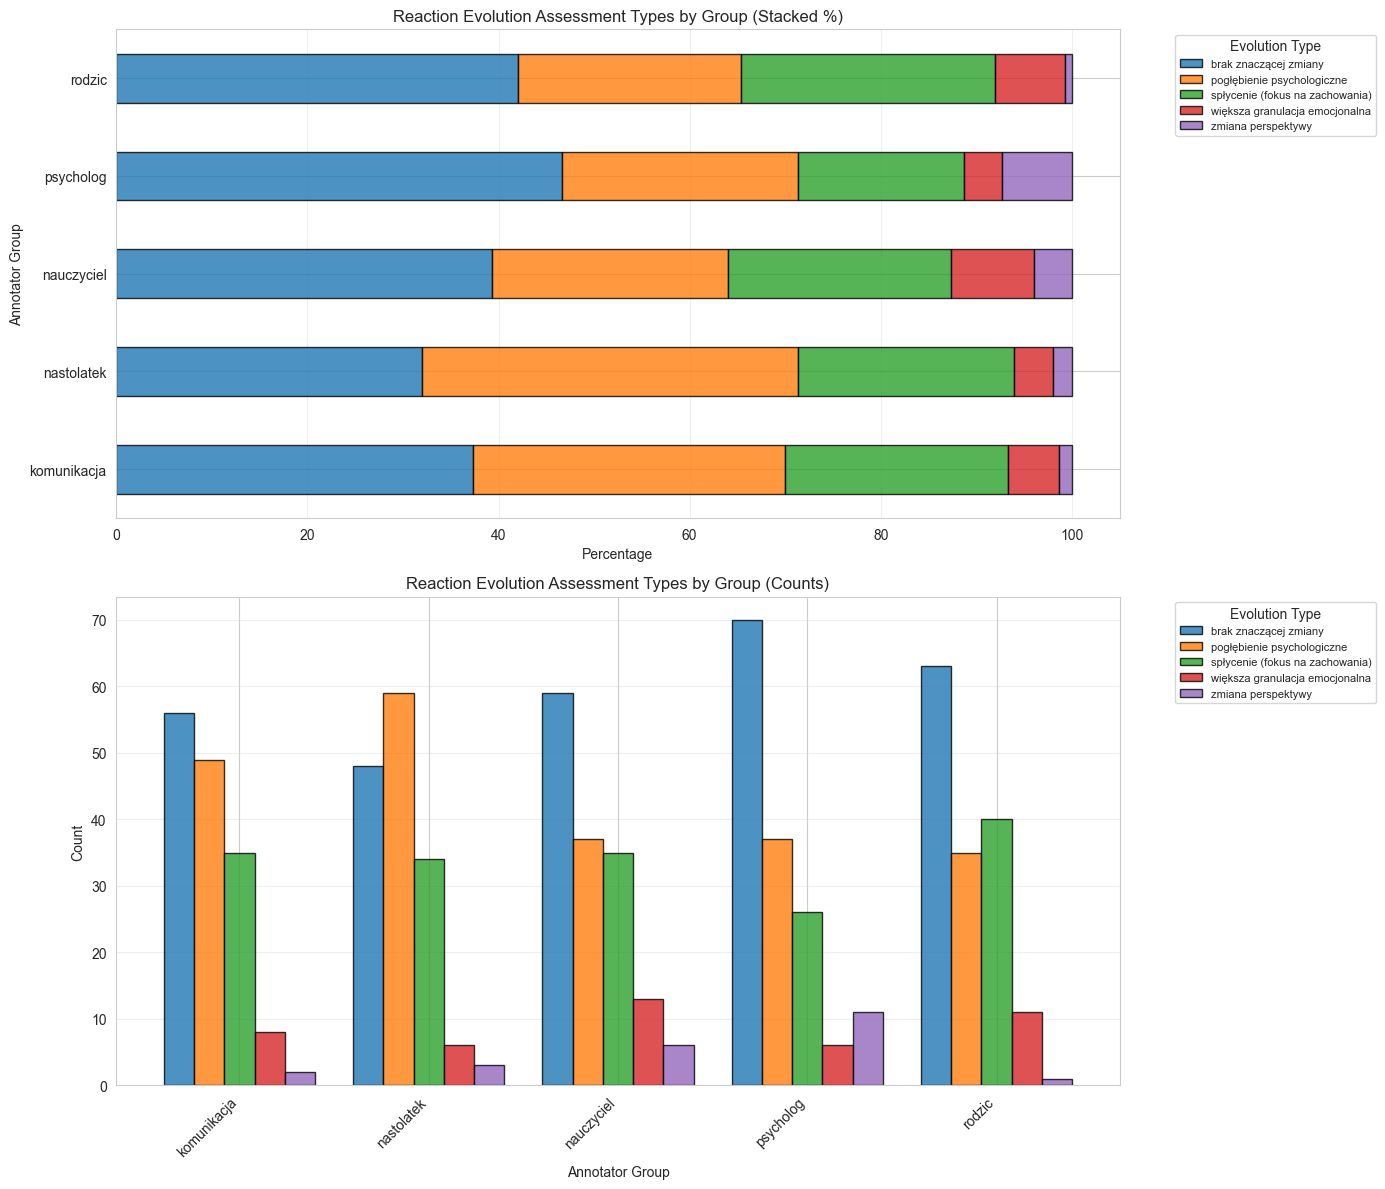


Reaction Evolution Assessment Types by Group (Counts):
reaction_evolution_assessment_type  brak znaczącej zmiany  \
annotator_group                                             
komunikacja                                            56   
nastolatek                                             48   
nauczyciel                                             59   
psycholog                                              70   
rodzic                                                 63   

reaction_evolution_assessment_type  pogłębienie psychologiczne  \
annotator_group                                                  
komunikacja                                                 49   
nastolatek                                                  59   
nauczyciel                                                  37   
psycholog                                                   37   
rodzic                                                      35   

reaction_evolution_assessment_type  spłycenie (fokus 

In [48]:
# Reaction evolution assessment types - By Group
groups = sorted(df['annotator_group'].unique())

# Create a crosstab for better visualization
reaction_type_by_group = pd.crosstab(df['annotator_group'], df['reaction_evolution_assessment_type'], normalize='index') * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Stacked bar chart
reaction_type_by_group.plot(kind='barh', stacked=True, ax=axes[0], edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Annotator Group')
axes[0].set_title('Reaction Evolution Assessment Types by Group (Stacked %)')
axes[0].legend(title='Evolution Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3, axis='x')

# Grouped bar chart with counts
reaction_type_counts_by_group = pd.crosstab(df['annotator_group'], df['reaction_evolution_assessment_type'])
reaction_type_counts_by_group.plot(kind='bar', ax=axes[1], edgecolor='black', alpha=0.8, width=0.8)
axes[1].set_xlabel('Annotator Group')
axes[1].set_ylabel('Count')
axes[1].set_title('Reaction Evolution Assessment Types by Group (Counts)')
axes[1].legend(title='Evolution Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nReaction Evolution Assessment Types by Group (Counts):")
print(reaction_type_counts_by_group)
print("\n\nReaction Evolution Assessment Types by Group (Percentages):")
print(reaction_type_by_group.round(1))

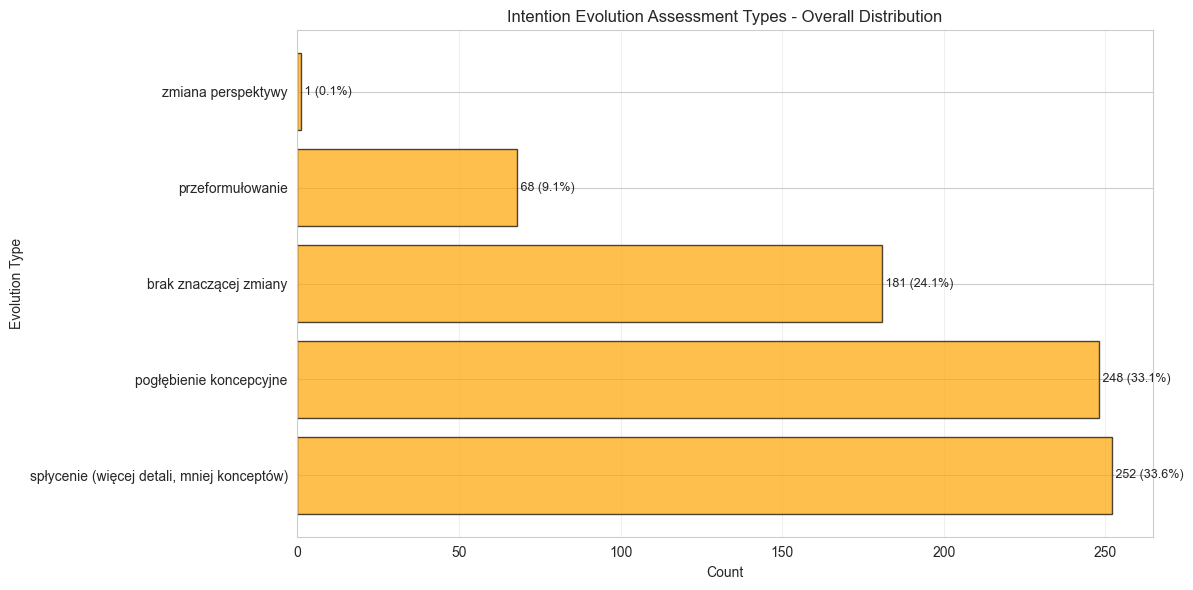

Intention Evolution Assessment Types:
intention_evolution_assessment_type
spłycenie (więcej detali, mniej konceptów)    252
pogłębienie koncepcyjne                       248
brak znaczącej zmiany                         181
przeformułowanie                               68
zmiana perspektywy                              1
Name: count, dtype: int64

Proportions:
intention_evolution_assessment_type
spłycenie (więcej detali, mniej konceptów)    33.6%
pogłębienie koncepcyjne                       33.1%
brak znaczącej zmiany                         24.1%
przeformułowanie                               9.1%
zmiana perspektywy                             0.1%
Name: proportion, dtype: object


In [49]:
# Intention evolution assessment types - Overall
intention_type_counts = df['intention_evolution_assessment_type'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(intention_type_counts.index, intention_type_counts.values, edgecolor='black', alpha=0.7, color='orange')
ax.set_xlabel('Count')
ax.set_ylabel('Evolution Type')
ax.set_title('Intention Evolution Assessment Types - Overall Distribution')
ax.grid(alpha=0.3, axis='x')

# Add value labels
for i, (idx, val) in enumerate(intention_type_counts.items()):
    ax.text(val, i, f' {val} ({val/len(df)*100:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Intention Evolution Assessment Types:")
print(df['intention_evolution_assessment_type'].value_counts())
print("\nProportions:")
print(df['intention_evolution_assessment_type'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

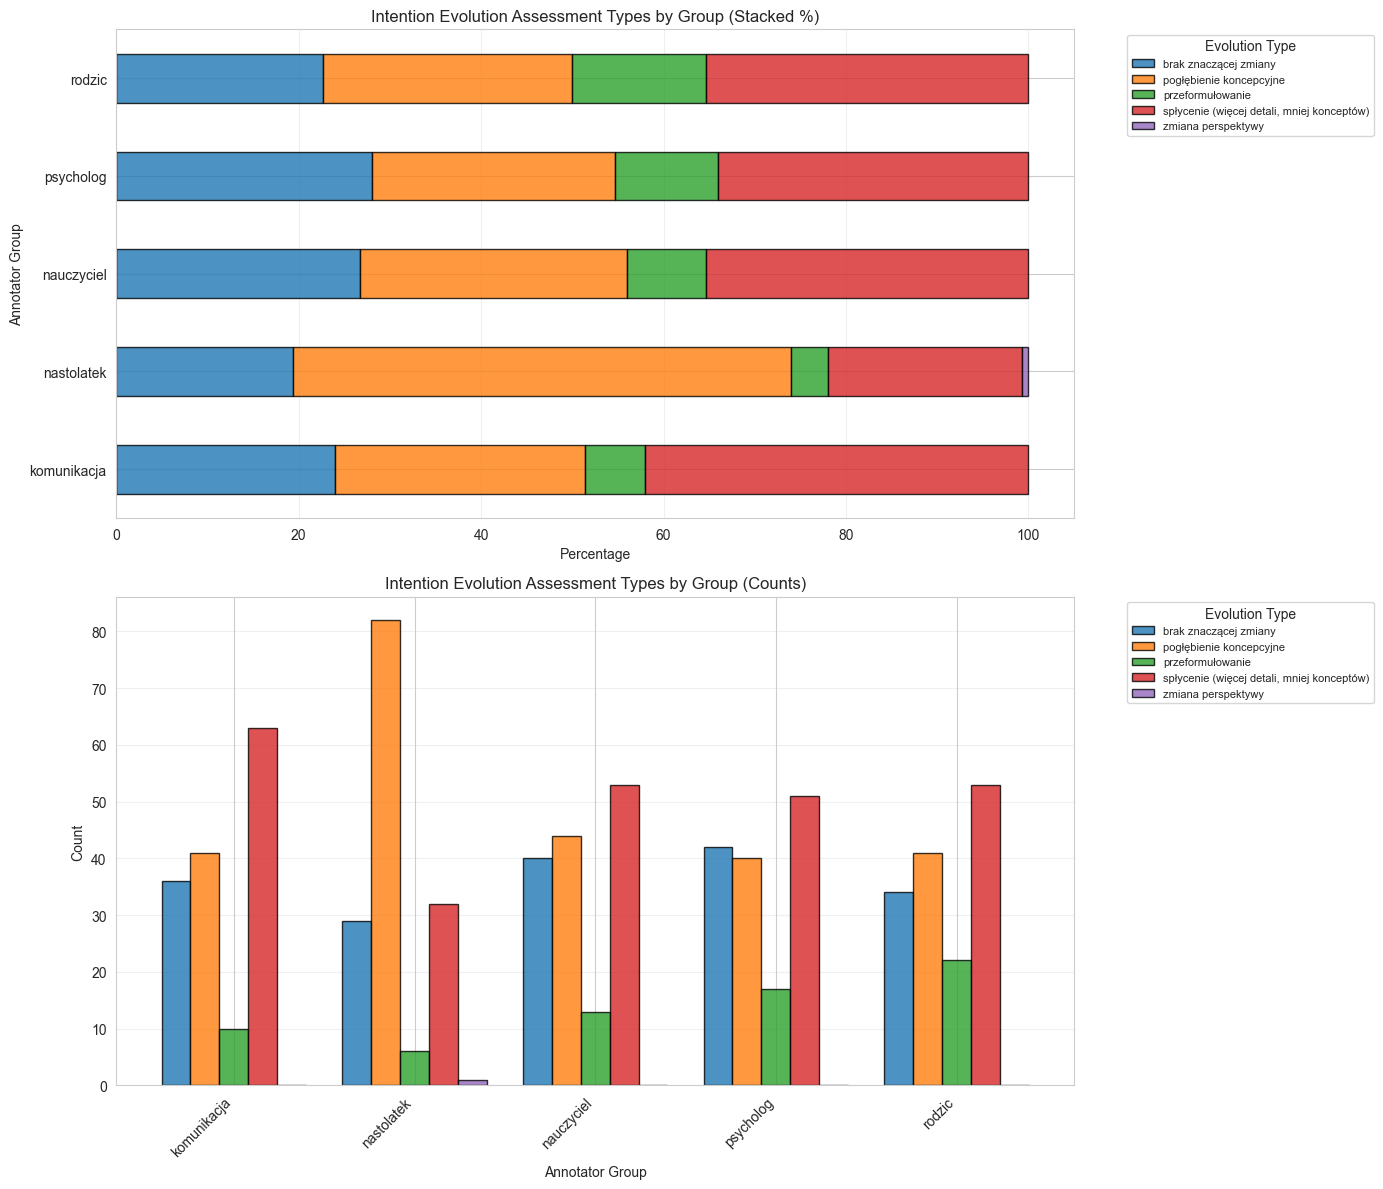


Intention Evolution Assessment Types by Group (Counts):
intention_evolution_assessment_type  brak znaczącej zmiany  \
annotator_group                                              
komunikacja                                             36   
nastolatek                                              29   
nauczyciel                                              40   
psycholog                                               42   
rodzic                                                  34   

intention_evolution_assessment_type  pogłębienie koncepcyjne  \
annotator_group                                                
komunikacja                                               41   
nastolatek                                                82   
nauczyciel                                                44   
psycholog                                                 40   
rodzic                                                    41   

intention_evolution_assessment_type  przeformułowanie  \
an

In [50]:
# Intention evolution assessment types - By Group

# Create a crosstab for better visualization
intention_type_by_group = pd.crosstab(df['annotator_group'], df['intention_evolution_assessment_type'], normalize='index') * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Stacked bar chart
intention_type_by_group.plot(kind='barh', stacked=True, ax=axes[0], edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Annotator Group')
axes[0].set_title('Intention Evolution Assessment Types by Group (Stacked %)')
axes[0].legend(title='Evolution Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3, axis='x')

# Grouped bar chart with counts
intention_type_counts_by_group = pd.crosstab(df['annotator_group'], df['intention_evolution_assessment_type'])
intention_type_counts_by_group.plot(kind='bar', ax=axes[1], edgecolor='black', alpha=0.8, width=0.8)
axes[1].set_xlabel('Annotator Group')
axes[1].set_ylabel('Count')
axes[1].set_title('Intention Evolution Assessment Types by Group (Counts)')
axes[1].legend(title='Evolution Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nIntention Evolution Assessment Types by Group (Counts):")
print(intention_type_counts_by_group)
print("\n\nIntention Evolution Assessment Types by Group (Percentages):")
print(intention_type_by_group.round(1))

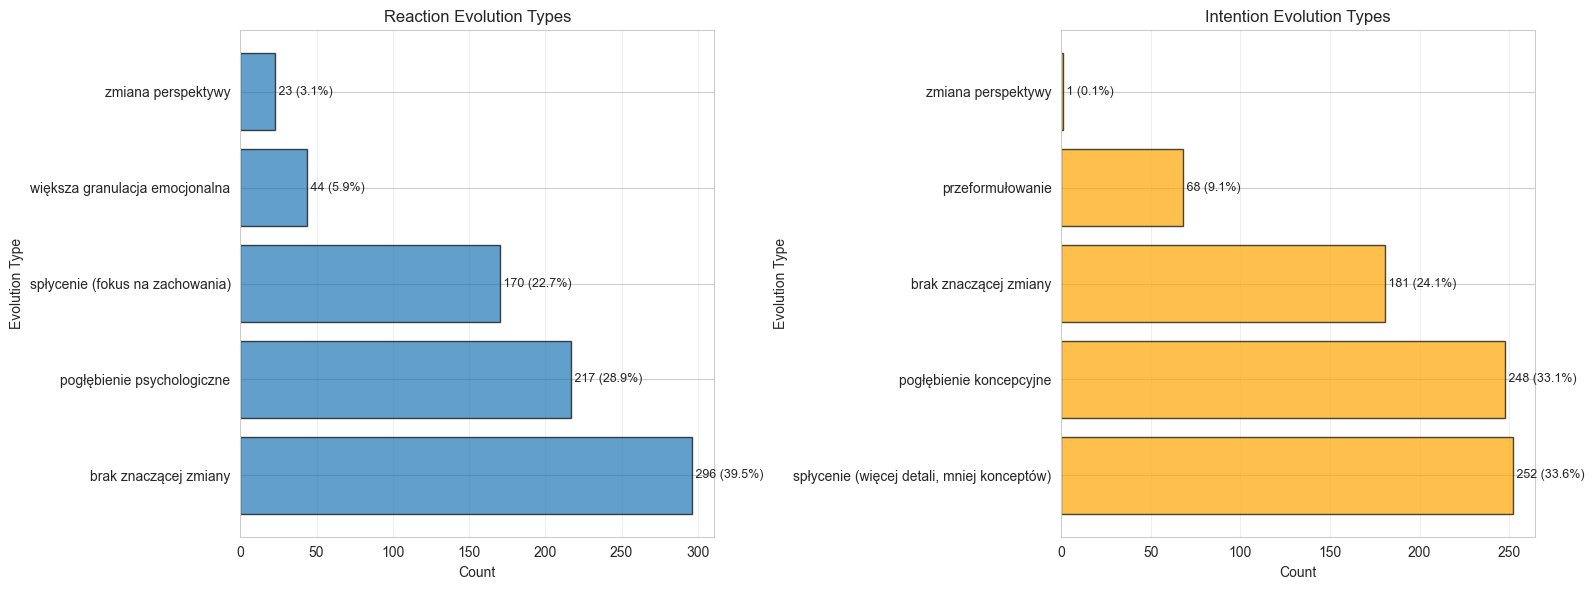


Comparison: Reaction vs Intention Evolution Types

Reaction types:
reaction_evolution_assessment_type
brak znaczącej zmiany              296
pogłębienie psychologiczne         217
spłycenie (fokus na zachowania)    170
większa granulacja emocjonalna      44
zmiana perspektywy                  23
Name: count, dtype: int64

Intention types:
intention_evolution_assessment_type
spłycenie (więcej detali, mniej konceptów)    252
pogłębienie koncepcyjne                       248
brak znaczącej zmiany                         181
przeformułowanie                               68
zmiana perspektywy                              1
Name: count, dtype: int64


In [51]:
# Compare evolution types between Reaction and Intention
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Reaction
reaction_type_counts = df['reaction_evolution_assessment_type'].value_counts()
axes[0].barh(reaction_type_counts.index, reaction_type_counts.values, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Evolution Type')
axes[0].set_title('Reaction Evolution Types')
axes[0].grid(alpha=0.3, axis='x')
for i, (idx, val) in enumerate(reaction_type_counts.items()):
    axes[0].text(val, i, f' {val} ({val/len(df)*100:.1f}%)', va='center', fontsize=9)

# Intention
intention_type_counts = df['intention_evolution_assessment_type'].value_counts()
axes[1].barh(intention_type_counts.index, intention_type_counts.values, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Evolution Type')
axes[1].set_title('Intention Evolution Types')
axes[1].grid(alpha=0.3, axis='x')
for i, (idx, val) in enumerate(intention_type_counts.items()):
    axes[1].text(val, i, f' {val} ({val/len(df)*100:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nComparison: Reaction vs Intention Evolution Types")
print("="*60)
print("\nReaction types:")
print(reaction_type_counts)
print("\nIntention types:")
print(intention_type_counts)

## 7. Certainty Analysis

## 8. Annotator Group Comparison

Statistics by Annotator Group:
                reaction_evolution_assessment_quality_change                \
                                                        mean    std median   
annotator_group                                                              
komunikacja                                            0.018  0.640    0.0   
nastolatek                                             0.011  0.699    0.0   
nauczyciel                                             0.052  0.518    0.0   
psycholog                                              0.117  0.456    0.0   
rodzic                                                -0.046  0.586    0.0   

                intention_evolution_assessment_quality_change                \
                                                         mean    std median   
annotator_group                                                               
komunikacja                                            -0.021  0.533    0.0   
nastolatek                  

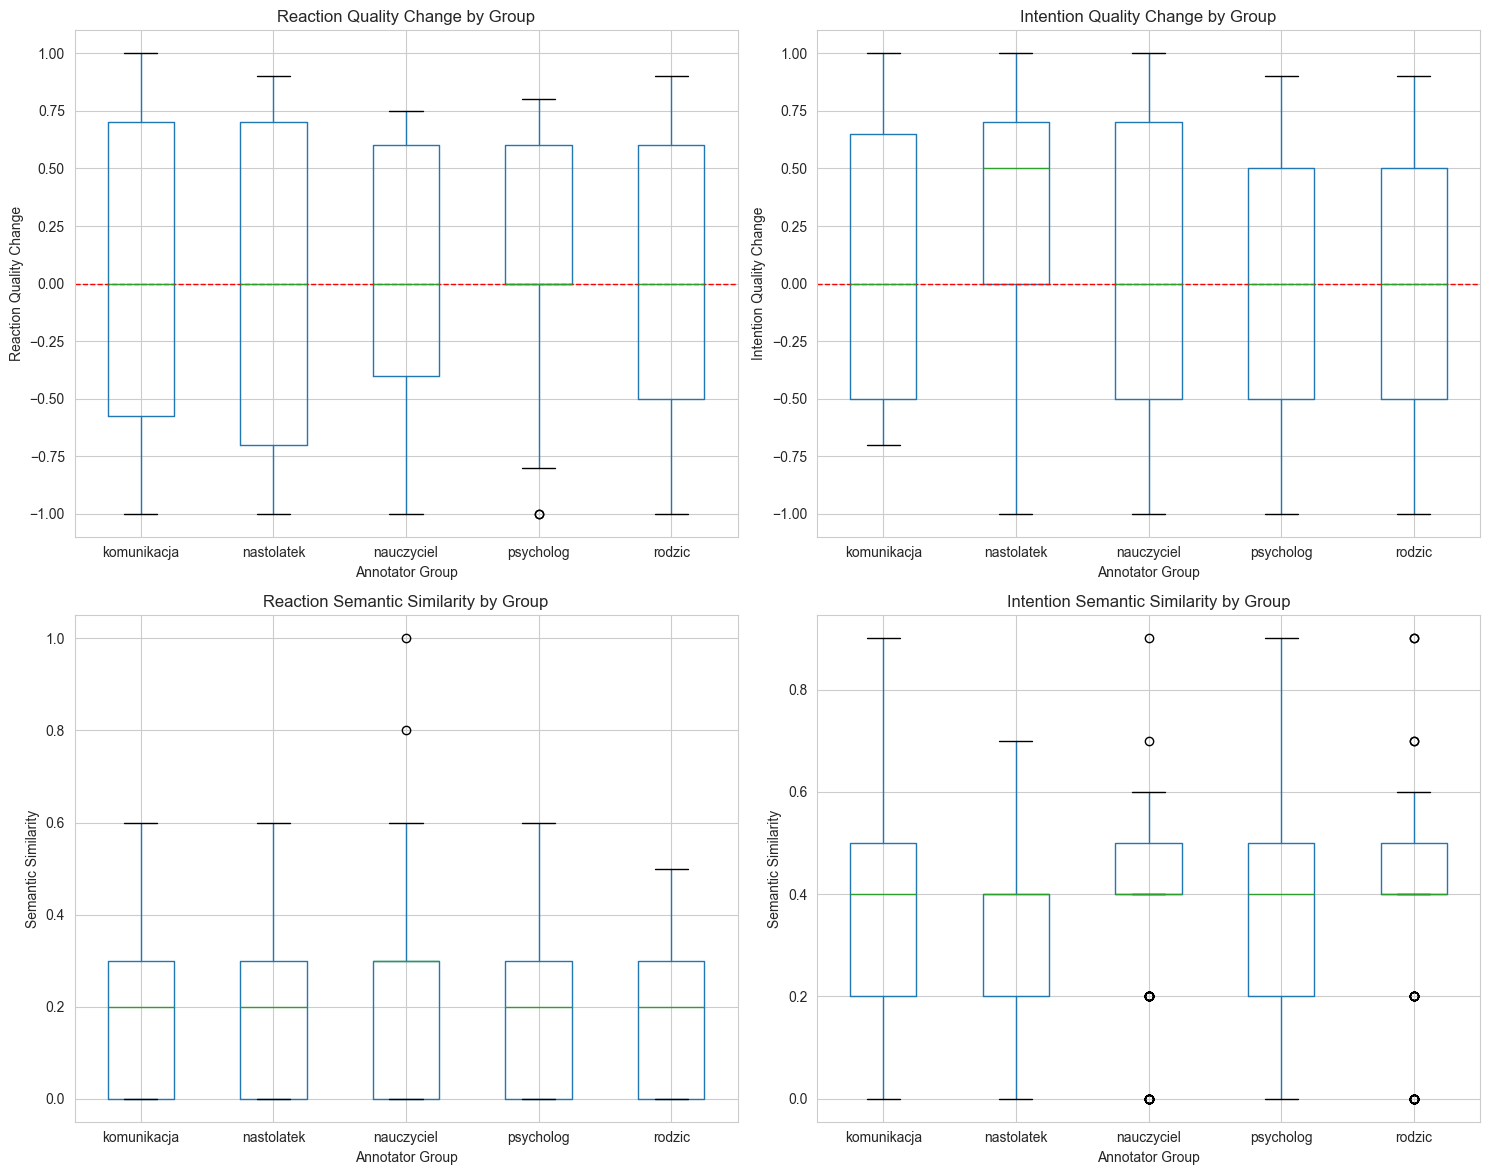

In [43]:
# Compare groups
group_stats = df.groupby('annotator_group').agg({
    'reaction_evolution_assessment_quality_change': ['mean', 'std', 'median'],
    'intention_evolution_assessment_quality_change': ['mean', 'std', 'median'],
    'certainty_change': ['mean', 'std', 'median'],
    'reaction_semantic_similarity': ['mean', 'std'],
    'intention_semantic_similarity': ['mean', 'std']
}).round(3)

print("Statistics by Annotator Group:")
print(group_stats)

# Visualize group comparisons
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Reaction quality change by group
df.boxplot(column='reaction_evolution_assessment_quality_change', by='annotator_group', ax=axes[0, 0])
axes[0, 0].set_xlabel('Annotator Group')
axes[0, 0].set_ylabel('Reaction Quality Change')
axes[0, 0].set_title('Reaction Quality Change by Group')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)

# Intention quality change by group
df.boxplot(column='intention_evolution_assessment_quality_change', by='annotator_group', ax=axes[0, 1])
axes[0, 1].set_xlabel('Annotator Group')
axes[0, 1].set_ylabel('Intention Quality Change')
axes[0, 1].set_title('Intention Quality Change by Group')
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1)

# Reaction semantic similarity by group
df.boxplot(column='reaction_semantic_similarity', by='annotator_group', ax=axes[1, 0])
axes[1, 0].set_xlabel('Annotator Group')
axes[1, 0].set_ylabel('Semantic Similarity')
axes[1, 0].set_title('Reaction Semantic Similarity by Group')

# Intention semantic similarity by group
df.boxplot(column='intention_semantic_similarity', by='annotator_group', ax=axes[1, 1])
axes[1, 1].set_xlabel('Annotator Group')
axes[1, 1].set_ylabel('Semantic Similarity')
axes[1, 1].set_title('Intention Semantic Similarity by Group')

plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()

## 9. Summary Statistics

In [44]:
# Overall summary
summary = {
    'Metric': [
        'Reaction Quality Change (mean)',
        'Intention Quality Change (mean)',
        'Certainty Change (mean)',
        'Reaction Improvement Rate',
        'Intention Improvement Rate',
        'Reaction Semantic Similarity (mean)',
        'Intention Semantic Similarity (mean)',
        'Correlation: Reaction-Intention Quality',
        'Correlation: Certainty-Reaction Quality',
        'Correlation: Certainty-Intention Quality'
    ],
    'Value': [
        f"{df['reaction_evolution_assessment_quality_change'].mean():.3f}",
        f"{df['intention_evolution_assessment_quality_change'].mean():.3f}",
        f"{df['certainty_change'].mean():.3f}",
        f"{(df['reaction_evolution_assessment_quality_change'] > 0).mean():.1%}",
        f"{(df['intention_evolution_assessment_quality_change'] > 0).mean():.1%}",
        f"{df['reaction_semantic_similarity'].mean():.3f}",
        f"{df['intention_semantic_similarity'].mean():.3f}",
        f"{df[['reaction_evolution_assessment_quality_change', 'intention_evolution_assessment_quality_change']].corr().iloc[0, 1]:.3f}",
        f"{df[['certainty_change', 'reaction_evolution_assessment_quality_change']].corr().iloc[0, 1]:.3f}",
        f"{df[['certainty_change', 'intention_evolution_assessment_quality_change']].corr().iloc[0, 1]:.3f}"
    ]
}

summary_df = pd.DataFrame(summary)
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)


SUMMARY STATISTICS
                                  Metric Value
          Reaction Quality Change (mean) 0.030
         Intention Quality Change (mean) 0.051
                 Certainty Change (mean) 0.261
               Reaction Improvement Rate 39.1%
              Intention Improvement Rate 42.0%
     Reaction Semantic Similarity (mean) 0.198
    Intention Semantic Similarity (mean) 0.374
 Correlation: Reaction-Intention Quality 0.204
 Correlation: Certainty-Reaction Quality 0.038
Correlation: Certainty-Intention Quality 0.004


## 10. Export Processed Data

## 11. T-Test Analysis: Quality Change Per Group

In [ ]:
from itertools import combinations

# Get groups
groups = sorted(df['annotator_group'].unique())

# ============================================================================
# PART 1: One-sample t-tests for Reaction Quality Change
# ============================================================================
print("="*80)
print("T-TESTS: REACTION QUALITY CHANGE BY GROUP")
print("="*80)
print("\nTesting if each group's quality change is significantly different from 0")
print("-"*80)

reaction_ttest_results = []

for group in groups:
    group_data = df[df['annotator_group'] == group]['reaction_evolution_assessment_quality_change'].dropna()
    
    # One-sample t-test against 0 (no change)
    t_stat, p_value = stats.ttest_1samp(group_data, 0)
    
    reaction_ttest_results.append({
        'Group': group,
        'n': len(group_data),
        'Mean': group_data.mean(),
        'Std': group_data.std(),
        't-statistic': t_stat,
        'p-value': p_value,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })
    
    print(f"\n{group}:")
    print(f"  n = {len(group_data)}")
    print(f"  Mean = {group_data.mean():.4f}")
    print(f"  Std = {group_data.std():.4f}")
    print(f"  t-statistic = {t_stat:.4f}")
    print(f"  p-value = {p_value:.4f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

reaction_ttest_df = pd.DataFrame(reaction_ttest_results)
print("\n" + "="*80)
print("\nSummary Table:")
print(reaction_ttest_df.to_string(index=False))
print("="*80)

# ============================================================================
# PART 2: One-sample t-tests for Intention Quality Change
# ============================================================================
print("\n\n")
print("="*80)
print("T-TESTS: INTENTION QUALITY CHANGE BY GROUP")
print("="*80)
print("\nTesting if each group's quality change is significantly different from 0")
print("-"*80)

intention_ttest_results = []

for group in groups:
    group_data = df[df['annotator_group'] == group]['intention_evolution_assessment_quality_change'].dropna()
    
    # One-sample t-test against 0 (no change)
    t_stat, p_value = stats.ttest_1samp(group_data, 0)
    
    intention_ttest_results.append({
        'Group': group,
        'n': len(group_data),
        'Mean': group_data.mean(),
        'Std': group_data.std(),
        't-statistic': t_stat,
        'p-value': p_value,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })
    
    print(f"\n{group}:")
    print(f"  n = {len(group_data)}")
    print(f"  Mean = {group_data.mean():.4f}")
    print(f"  Std = {group_data.std():.4f}")
    print(f"  t-statistic = {t_stat:.4f}")
    print(f"  p-value = {p_value:.4f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

intention_ttest_df = pd.DataFrame(intention_ttest_results)
print("\n" + "="*80)
print("\nSummary Table:")
print(intention_ttest_df.to_string(index=False))
print("="*80)

# ============================================================================
# PART 3: Visualize T-test results
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Reaction Quality Change
reaction_means = [r['Mean'] for r in reaction_ttest_results]
reaction_stds = [r['Std'] for r in reaction_ttest_results]
reaction_significant = [r['Significant (p<0.05)'] for r in reaction_ttest_results]
colors_reaction = ['green' if sig == 'Yes' else 'gray' for sig in reaction_significant]

axes[0].bar(groups, reaction_means, yerr=reaction_stds, capsize=5, 
            color=colors_reaction, alpha=0.7, edgecolor='black')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2, label='No change')
axes[0].set_xlabel('Annotator Group')
axes[0].set_ylabel('Mean Quality Change')
axes[0].set_title('Reaction Quality Change by Group\n(Green = Significant, Gray = Not Significant)')
axes[0].grid(alpha=0.3, axis='y')
axes[0].legend()
axes[0].set_xticklabels(groups, rotation=45, ha='right')

# Add p-values as text
for i, (group, result) in enumerate(zip(groups, reaction_ttest_results)):
    axes[0].text(i, reaction_means[i] + reaction_stds[i] + 0.02, 
                f"p={result['p-value']:.3f}", 
                ha='center', va='bottom', fontsize=8)

# Intention Quality Change
intention_means = [r['Mean'] for r in intention_ttest_results]
intention_stds = [r['Std'] for r in intention_ttest_results]
intention_significant = [r['Significant (p<0.05)'] for r in intention_ttest_results]
colors_intention = ['green' if sig == 'Yes' else 'gray' for sig in intention_significant]

axes[1].bar(groups, intention_means, yerr=intention_stds, capsize=5,
            color=colors_intention, alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='No change')
axes[1].set_xlabel('Annotator Group')
axes[1].set_ylabel('Mean Quality Change')
axes[1].set_title('Intention Quality Change by Group\n(Green = Significant, Gray = Not Significant)')
axes[1].grid(alpha=0.3, axis='y')
axes[1].legend()
axes[1].set_xticklabels(groups, rotation=45, ha='right')

# Add p-values as text
for i, (group, result) in enumerate(zip(groups, intention_ttest_results)):
    axes[1].text(i, intention_means[i] + intention_stds[i] + 0.02,
                f"p={result['p-value']:.3f}",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ============================================================================
# PART 4: Pairwise t-tests for Reaction Quality Change
# ============================================================================
print("\n\n")
print("="*80)
print("PAIRWISE T-TESTS: REACTION QUALITY CHANGE BETWEEN GROUPS")
print("="*80)
print("\nIndependent samples t-tests comparing groups")
print("-"*80)

pairwise_reaction_results = []

for group1, group2 in combinations(groups, 2):
    data1 = df[df['annotator_group'] == group1]['reaction_evolution_assessment_quality_change'].dropna()
    data2 = df[df['annotator_group'] == group2]['reaction_evolution_assessment_quality_change'].dropna()
    
    # Independent samples t-test
    t_stat, p_value = stats.ttest_ind(data1, data2)
    
    pairwise_reaction_results.append({
        'Group 1': group1,
        'Group 2': group2,
        'Mean 1': data1.mean(),
        'Mean 2': data2.mean(),
        'Diff': data1.mean() - data2.mean(),
        't-statistic': t_stat,
        'p-value': p_value,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

pairwise_reaction_df = pd.DataFrame(pairwise_reaction_results)
print("\n" + pairwise_reaction_df.round(4).to_string(index=False))
print("\n" + "="*80)

# Count significant comparisons
n_significant = (pairwise_reaction_df['p-value'] < 0.05).sum()
print(f"\nSignificant pairwise differences: {n_significant}/{len(pairwise_reaction_df)}")

# ============================================================================
# PART 5: Pairwise t-tests for Intention Quality Change
# ============================================================================
print("\n\n")
print("="*80)
print("PAIRWISE T-TESTS: INTENTION QUALITY CHANGE BETWEEN GROUPS")
print("="*80)
print("\nIndependent samples t-tests comparing groups")
print("-"*80)

pairwise_intention_results = []

for group1, group2 in combinations(groups, 2):
    data1 = df[df['annotator_group'] == group1]['intention_evolution_assessment_quality_change'].dropna()
    data2 = df[df['annotator_group'] == group2]['intention_evolution_assessment_quality_change'].dropna()
    
    # Independent samples t-test
    t_stat, p_value = stats.ttest_ind(data1, data2)
    
    pairwise_intention_results.append({
        'Group 1': group1,
        'Group 2': group2,
        'Mean 1': data1.mean(),
        'Mean 2': data2.mean(),
        'Diff': data1.mean() - data2.mean(),
        't-statistic': t_stat,
        'p-value': p_value,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

pairwise_intention_df = pd.DataFrame(pairwise_intention_results)
print("\n" + pairwise_intention_df.round(4).to_string(index=False))
print("\n" + "="*80)

# Count significant comparisons
n_significant = (pairwise_intention_df['p-value'] < 0.05).sum()
print(f"\nSignificant pairwise differences: {n_significant}/{len(pairwise_intention_df)}")

## 12. Export Processed Data

In [ ]:
# Save processed data with calculated metrics
df.to_csv('annotated_results_with_analysis.csv', index=False)
print("Processed data saved to 'annotated_results_with_analysis.csv'")

# Save summary statistics
summary_df.to_csv('analysis_summary.csv', index=False)
print("Summary statistics saved to 'analysis_summary.csv'")

# Save t-test results
reaction_ttest_df.to_csv('reaction_ttest_results.csv', index=False)
print("Reaction t-test results saved to 'reaction_ttest_results.csv'")

intention_ttest_df.to_csv('intention_ttest_results.csv', index=False)
print("Intention t-test results saved to 'intention_ttest_results.csv'")

pairwise_reaction_df.to_csv('pairwise_reaction_ttest_results.csv', index=False)
print("Pairwise reaction t-test results saved to 'pairwise_reaction_ttest_results.csv'")

pairwise_intention_df.to_csv('pairwise_intention_ttest_results.csv', index=False)
print("Pairwise intention t-test results saved to 'pairwise_intention_ttest_results.csv'")